In [1]:
%load_ext autoreload
%autoreload 2

# Подготовка данных

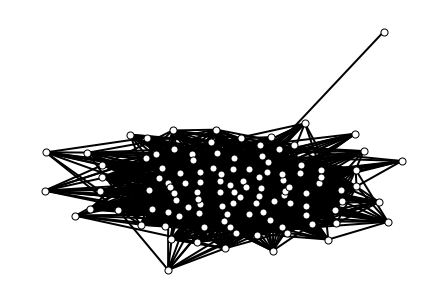

In [2]:
import numpy as np
import pandas as pd

from base.utils import read_source, build_graph_from_pandas, plot_graph

data = read_source("data/ht09_contact_list.dat")
G = build_graph_from_pandas(data)
plot_graph(G)

# Сравнение трёх дней

Получим графы всех трёх дней конференции и для каждого посчитаем распределения на коммьюнити, центральности и разные другие меры. 

Day 1, Modularity of Louvain: 0.164
Day 2, Modularity of Louvain: 0.170
Day 3, Modularity of Louvain: 0.190


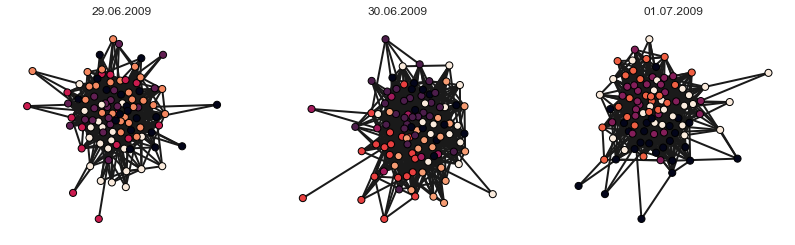

In [11]:
from base.utils import extract_relevant_data, graph_features, measure_centralities
import community
import matplotlib.pyplot as plt

f, ax = plt.subplots(ncols=3, figsize=(14, 4))

start = pd.to_datetime("2009-06-29")
all_people = pd.concat([data["person1"], data["person2"]]).unique()

partitions = []
features = []
centralities = []

for offset in range(3):
    day = extract_relevant_data(data, start + pd.to_timedelta(offset, unit="d"), \
                                start + pd.to_timedelta(offset + 1, unit="d"))
    G_day = build_graph_from_pandas(day)
    features.append(graph_features(G_day))
    partition = community.best_partition(G_day)
    plot_graph(G_day, node_color=list(partition.values()), ax=ax[offset])
    ax[offset].set_title((start + pd.to_timedelta(offset, unit="d")).strftime("%d.%m.%Y"))
    
    G_day_full = build_graph_from_pandas(day, all_people=all_people)
    full_partition = community.best_partition(G_day_full)
    partitions.append(full_partition)
    
    centralities.append(measure_centralities(G_day_full))
    
    modularity = community.modularity(full_partition, G_day_full)
    print(f"Day {offset + 1}, Modularity of Louvain: {modularity:.3f}")

Посмотрим на метрику BCubed разделения на коммьюнити в разные дни.

In [8]:
from base.utils import bcubed_score

for i, j in [(0, 1), (0, 2), (1, 2)]:
    p, r, f1 = bcubed_score(partitions[i], partitions[j])
    print(f"Day {i + 1} vs Day {j + 1}: precision {p * 100:.2f}%, recall {r * 100:.2f}%, f1 {f1 * 100:.2f}%")
    
print("\n")

num_repeats = 100
for i in range(3):
    p = r = f1 = 0.
    for _ in range(num_repeats):
        max_cluster = max(partitions[i].values())
        random_partition = {key: np.random.choice(max_cluster + 1) for key in partitions[i].keys()}
        p_cur, r_cur, f1_cur = bcubed_score(partitions[i], random_partition)
        p += p_cur / num_repeats
        r += r_cur / num_repeats
        f1 += f1_cur / num_repeats  

    print(f"Day {i + 1} vs Random: precision {p * 100:.2f}%, recall {r * 100:.2f}%, f1 {f1 * 100:.2f}%")

Day 1 vs Day 2: precision 27.70%, recall 34.63%, f1 30.78%
Day 1 vs Day 3: precision 30.41%, recall 29.07%, f1 29.72%
Day 2 vs Day 3: precision 38.71%, recall 31.08%, f1 34.48%


Day 1 vs Random: precision 28.52%, recall 21.13%, f1 24.27%
Day 2 vs Random: precision 30.27%, recall 19.59%, f1 23.78%
Day 3 vs Random: precision 30.24%, recall 22.49%, f1 25.79%


Посмотрим на то, как разные фичи графов различались в разные дни.

In [5]:
features_df = pd.DataFrame(features)
features_df["day"] = start + pd.to_timedelta(features_df.index, unit="d")
features_df

,n_nodes,n_edges,mean_degree,max_degree,connected_components,max_component_size,clustering_coef,diameter,average_distance,day
0,100,946,18.920000,78,1,100,0.456155,3,1.883636,2009-06-29
1,102,1061,20.803922,54,1,102,0.394112,4,1.881771,2009-06-30
2,97,928,19.134021,44,1,97,0.362326,4,1.900988,2009-07-01


In [12]:
features_df[["day", "mean_degree", "max_degree", "clustering_coef", "diameter", "average_distance"]]

,day,mean_degree,max_degree,clustering_coef,diameter,average_distance
0,2009-06-29,18.920000,78,0.456155,3,1.883636
1,2009-06-30,20.803922,54,0.394112,4,1.881771
2,2009-07-01,19.134021,44,0.362326,4,1.900988


Посмотрим на зависимости центральностей от их значений в предыдущий день.

Centrality: closeness, Pearson corr: 0.475, Spearman corr: 0.521
Centrality: betweenness, Pearson corr: 0.429, Spearman corr: 0.512
Centrality: katz, Pearson corr: 0.086, Spearman corr: 0.102
Centrality: pagerank, Pearson corr: 0.424, Spearman corr: 0.430


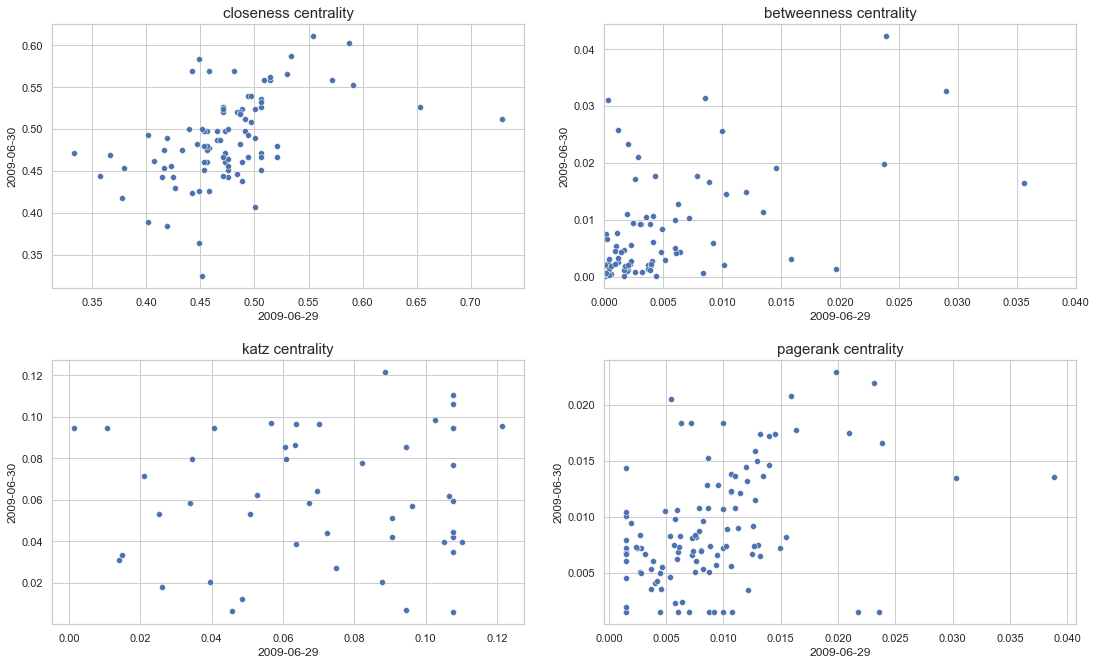

In [6]:
from scipy.stats import pearsonr, spearmanr

import seaborn as sns
sns.set(style="whitegrid")

day_i = 0
day_j = 1

f, ax = plt.subplots(ncols=2, nrows=2, figsize=(16, 10))
plt.tight_layout(pad=4)

for i, centrality in enumerate(["closeness", "betweenness", "katz", "pagerank"]):
    x = np.array(list(centralities[day_i][centrality].values()))
    y = np.array(list(centralities[day_j][centrality].values()))
    mask = (x > 0) & (y > 0)
    sns.scatterplot(x=x[mask], y=y[mask], ax=ax[i // 2][i % 2])
    ax[i // 2][i % 2].set_xlabel("2009-06-29")
    ax[i // 2][i % 2].set_ylabel("2009-06-30")
    ax[i // 2][i % 2].set_title(f"{centrality} centrality", fontdict={"fontsize": 15})
    
    if centrality == "betweenness":
        ax[i // 2][i % 2].set_xlim(0, 0.04)
        
    pcorr = pearsonr(x[mask], y[mask])
    scorr = spearmanr(x[mask], y[mask])
    print(f"Centrality: {centrality}, Pearson corr: {pcorr[0]:.3f}, Spearman corr: {scorr[0]:.3f}")